In [1]:
using BenchmarkTools
using Distributed
using Plots
using ScikitLearn
using StatsBase
using LoopVectorization
using DataStructures
using TimerOutputs
using TrackingHeaps
# using HDF5, JLD

In [2]:
@sk_import datasets: (fetch_covtype)

PyObject <function fetch_covtype at 0x7f829a9313a0>

In [3]:
# save("../data/digits_data.jld", "data", digits_data)

In [4]:
digits_data = fetch_covtype();

In [5]:
X_digits = abs.(digits_data["data"]);
X_digits = transpose(X_digits);

In [6]:
struct NaiveGreedy
    X::Matrix{Float64}
end

struct LazyGreedy
    X::Matrix{Float64}
end

struct Result
    ranking::Vector{Int32}
    gains::Vector{Float64}
end

In [7]:
function fill!(pq::PriorityQueue, k, v)
    for i in eachindex(k)
        enqueue!(pq, k[i], v[i])
    end
end;

In [8]:
# function get_gains!(X, current_values, idxs, gains)
#     Threads.@threads for i in eachindex(idxs)
#         idx = idxs[i]
#         @fastmath gains[i] = sum(sqrt.(current_values + view(X, :, idx)))
#     end
# end;

In [9]:
function get_gains!(X, current_values, idxs, gains)
    @inbounds Threads.@threads for i in eachindex(idxs)
        s = 0.0
        for j in eachindex(current_values)
            s += @fastmath sqrt(current_values[j] + X[j, idxs[i]])
        end
        gains[i] = s
    end
end;

In [10]:
function get_gains(X, current_values, idxs::Int)
    s = 0.0
    @tturbo for j in eachindex(current_values)
        s += sqrt(current_values[j] + X[j, idxs])
    end
    return s
end;

In [11]:
# @code_native get_gains!(rand(10, 10), rand(10), rand(1:10, 10), rand(10))

In [12]:
function calculate_gains!(X, gains, current_values, idxs, current_concave_value_sum)
    get_gains!(X, current_values, idxs, gains)
    
    gains .-= current_concave_value_sum
    return gains
end;

In [13]:
function calculate_gains(X, current_values, idxs::Int, current_concave_value_sum)
    return get_gains(X, current_values, idxs) - current_concave_value_sum
end;

In [14]:
function fit(optimizer::NaiveGreedy, k)
    d, n = size(optimizer.X)

    cost = 0.0

    ranking = Int32[]
    total_gains = Float64[]

    mask = zeros(Int8, n)
    current_values = zeros(Float64, d)
    current_concave_values = sqrt.(current_values)
    current_concave_values_sum = sum(current_concave_values)

    idxs = 1:n

    gains = zeros(Float64, size(idxs)[1])
    while cost < k
        gains = calculate_gains!(optimizer.X, gains, current_values, idxs, current_concave_values_sum)

        idx = argmax(gains)
        best_idx = idxs[idx]
        curr_cost = 1.

        if cost + curr_cost > k
            break
        end

        cost += curr_cost
        # Calculate gains
        gain = gains[idx] * curr_cost

        # Select next
        current_values += view(optimizer.X, :, best_idx)
        current_concave_values .= sqrt.(current_values)
        current_concave_values_sum = sum(current_concave_values)

        push!(ranking, best_idx)
        push!(total_gains, gain)

        mask[best_idx] = 1
        idxs = findall(==(0), mask)
    end
    return Result(ranking, total_gains)
end;

In [15]:
function fit(optimizer::LazyGreedy, k)
    d, n = size(optimizer.X)

    cost = 0.0
    curr_cost = 1.

    ranking = Int32[]
    total_gains = Float64[]

    mask = zeros(Int8, n)
    current_values = zeros(Float64, d)
    current_concave_values = sqrt.(current_values)
    current_concave_values_sum = sum(current_concave_values)

    idxs = 1:n

    gains = zeros(Float64, size(idxs)[1])
    calculate_gains!(optimizer.X, gains, current_values, idxs, current_concave_values_sum)
    pq = PriorityQueue{Int64, Float64}(Base.Order.Reverse)
    fill!(pq, idxs, gains)

    while cost < k
        if length(pq) == 0
            return
        end
        
        best_gain = -Inf
        best_idx = -1
        
        while true
            idx = dequeue!(pq)

            if cost + curr_cost > k
                continue
            end

            if best_idx == idx
                break
            end

            gain = calculate_gains(optimizer.X, current_values, idx, current_concave_values_sum)
            enqueue!(pq, idx, gain)

            if gain > best_gain
                best_gain = gain
                best_idx = idx
            elseif gain == best_gain && best_gain == 0.0
                best_gain = gain
                best_idx = idx
                break
            end
        end

        cost += curr_cost

        # Select next
        current_values += view(optimizer.X, :, best_idx)
        current_concave_values .= sqrt.(current_values)
        current_concave_values_sum = sum(current_concave_values)

        push!(ranking, best_idx)
        push!(total_gains, best_gain)

        mask[best_idx] = 1
        idxs = findall(==(0), mask)
    end
    return Result(ranking, total_gains)
end;

In [16]:
k = 1000;

In [ ]:
opt1 = NaiveGreedy(X_digits);
res1 = @btime fit(opt1, k);

In [17]:
opt1 = NaiveGreedy(X_digits);
res1 = @btime fit(opt1, k);
bench1 = @benchmark fit(opt1, k);
t1 = bench1.times[1]/1e9;

  19.390 s (104801 allocations: 8.80 GiB)


In [18]:
opt2 = LazyGreedy(X_digits);
res2 = @btime fit(opt2, k);
bench2 = @benchmark fit(opt2, k);
t2 = bench2.times[1]/1e9;

LoadError: UndefVarError: to not defined

In [19]:
bench0 = @benchmark begin
    idxs = StatsBase.sample(1:size(X_digits)[2], k)
    X_subset = X_digits[:, idxs]
    global gains1 = cumsum(X_subset, dims=2)
    global gains1 = vec(sum(sqrt.(gains1), dims=1))
end
t0 = bench0.times[1]/1e9;

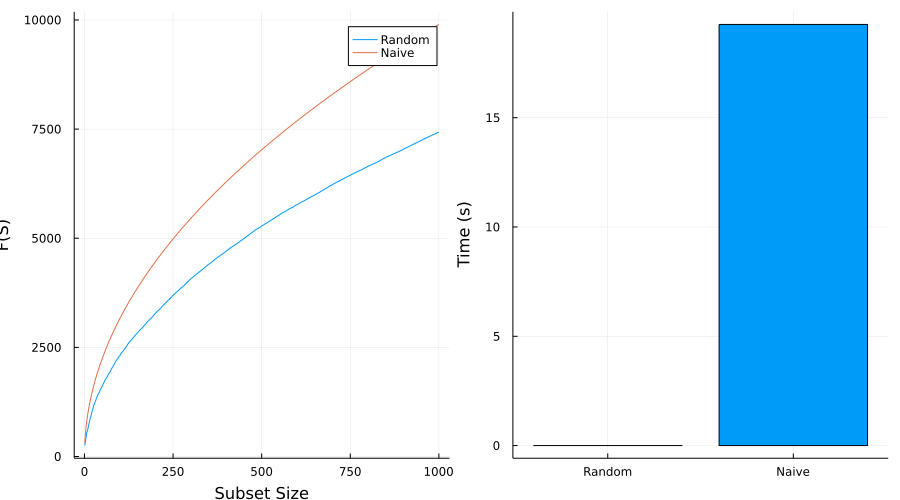

In [20]:
p1 = plot(gains1, label="Random")
plot!(cumsum(res1.gains), label="Naive")
ylabel!("F(S)", fontsize=12)
xlabel!("Subset Size", fontsize=12)

labels = ["Random", "Naive"]
p2 = bar(labels, [t0, t1], labels=labels, legend=false)
ylabel!("Time (s)")

plot(p1, p2, layout = (1, 2))
plot!(size=(900,500))